Filtering data for Product 1...
Product 1 data: 1148 records
pre_pandemic: 209 records (2016-01-03 to 2019-12-29)
pandemic: 104 records (2020-01-05 to 2021-12-26)
post_pandemic: 157 records (2022-01-02 to 2024-12-29)
pre_pandemic: 209 records (2016-01-03 to 2019-12-29)
pandemic: 104 records (2020-01-05 to 2021-12-26)
post_pandemic: 157 records (2022-01-02 to 2024-12-29)
pre_pandemic residuals - MAE: 2.94, RMSE: 3.71, MAE%: 4.07%
pandemic residuals - MAE: 94.03, RMSE: 128.30, MAE%: 44.32%
post_pandemic residuals - MAE: 64.70, RMSE: 92.94, MAE%: 36.69%
pre_pandemic: 0 anomalies (0.0% of data)
pandemic: 7 anomalies (6.7% of data)
post_pandemic: 17 anomalies (10.8% of data)


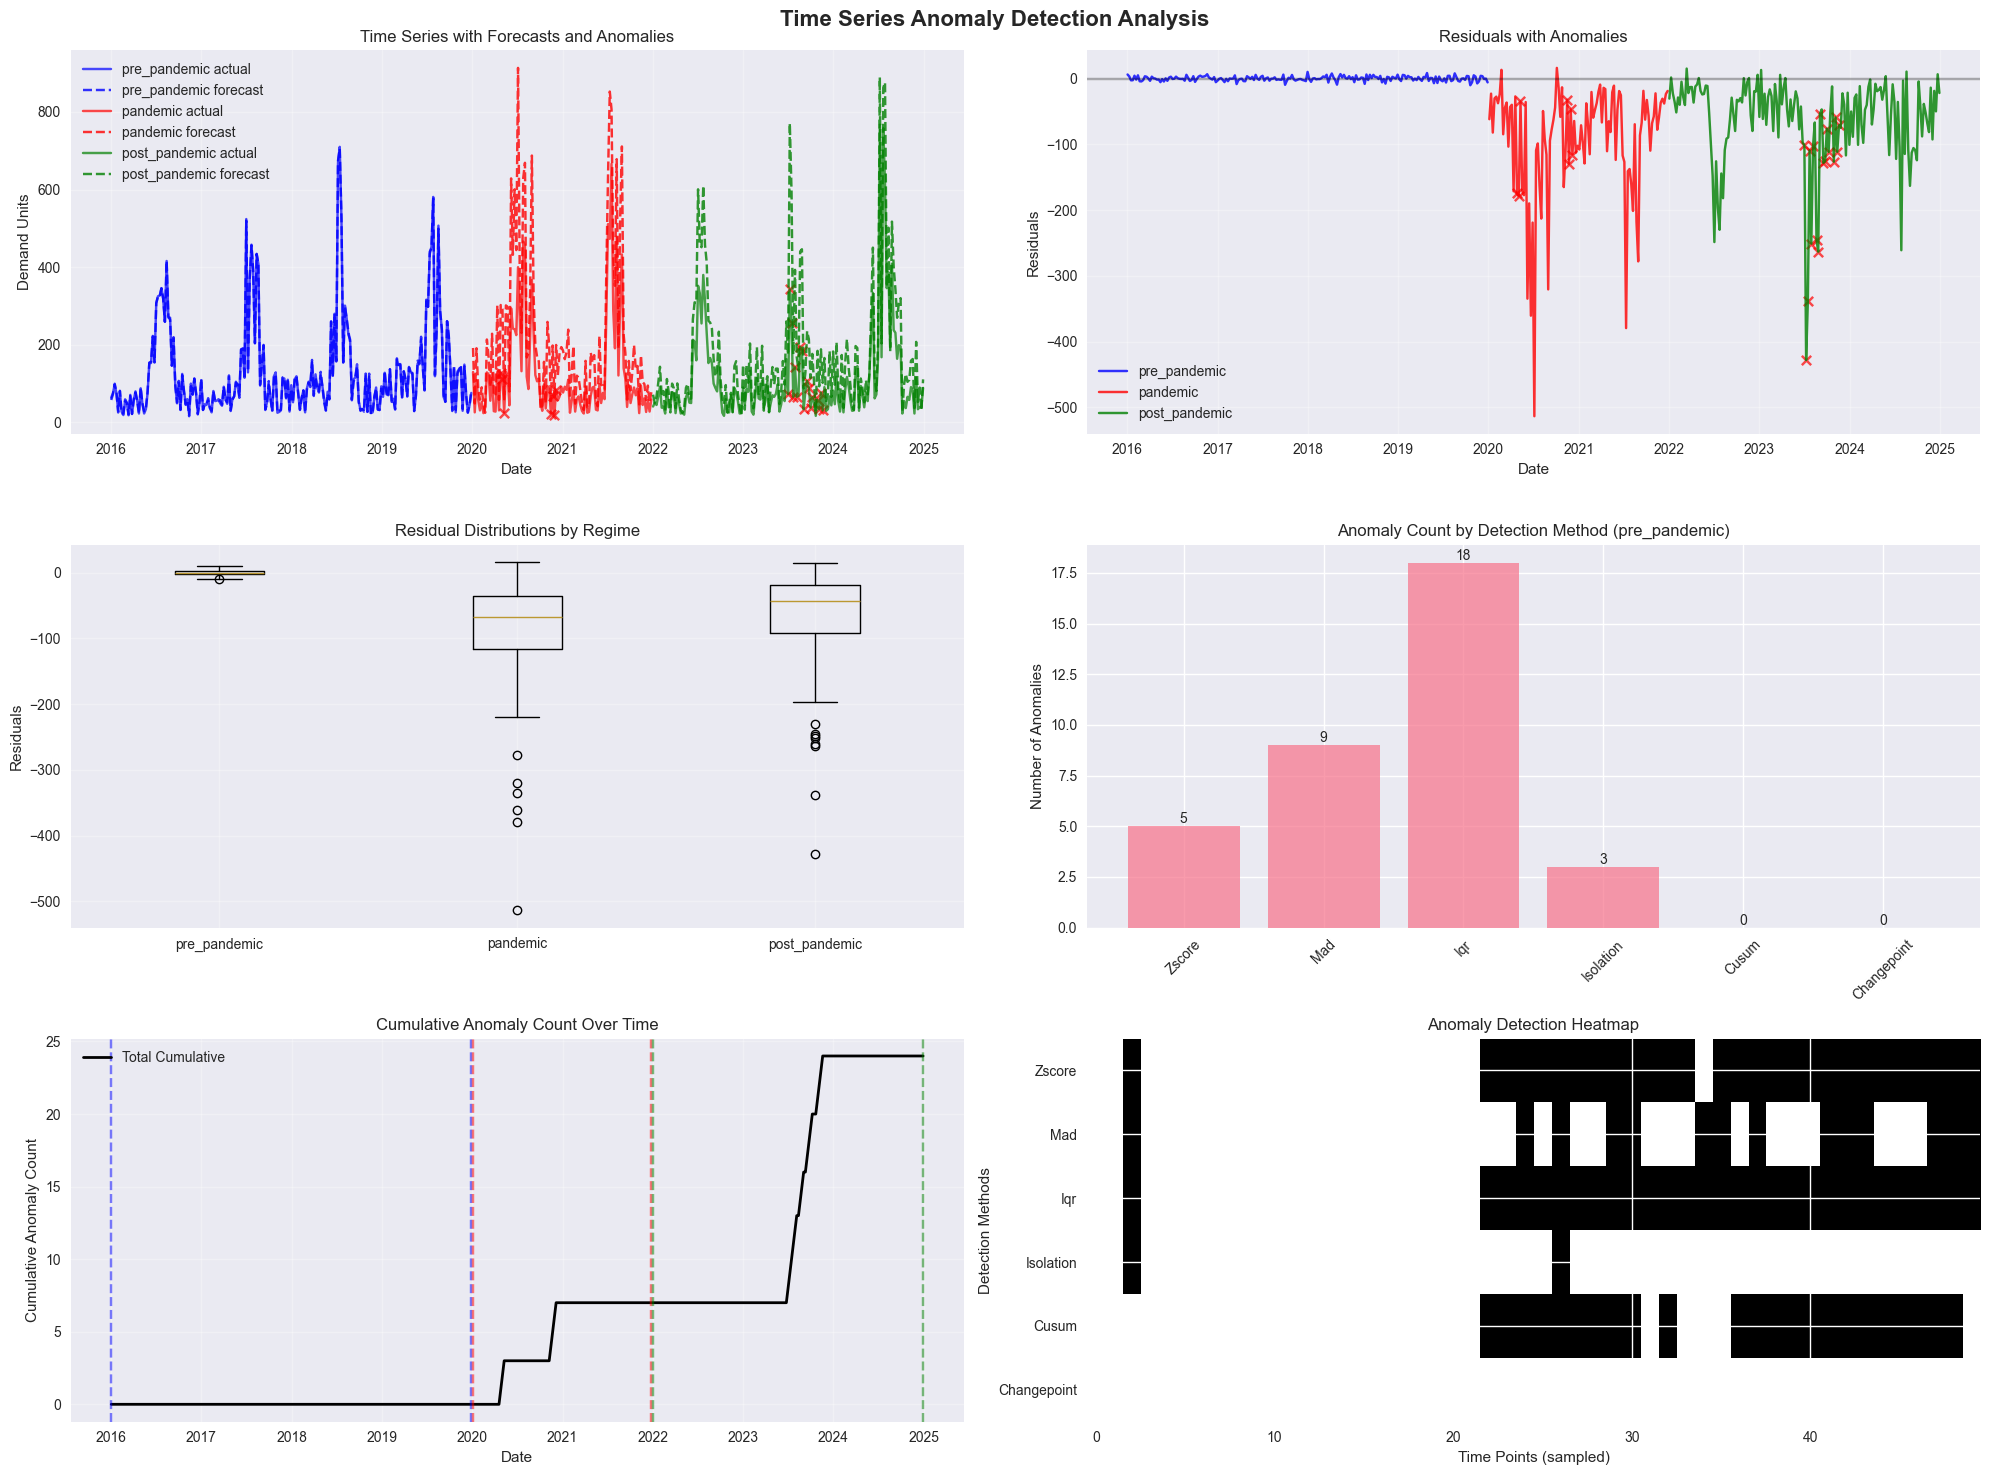

pre_pandemic: 209 records (2016-01-03 to 2019-12-29)
pandemic: 104 records (2020-01-05 to 2021-12-26)
post_pandemic: 157 records (2022-01-02 to 2024-12-29)
Pre Pandemic: 209 records
  Date range: 2016-01-03 00:00:00 to 2019-12-29 00:00:00
  Mean demand: 130.84
  Std demand: 123.97
Pandemic: 104 records
  Date range: 2020-01-05 00:00:00 to 2021-12-26 00:00:00
  Mean demand: 124.92
  Std demand: 127.99
Post Pandemic: 157 records
  Date range: 2022-01-02 00:00:00 to 2024-12-29 00:00:00
  Mean demand: 109.46
  Std demand: 119.67
Pre Pandemic:
  Mean residual: -0.00
  Std residual: 3.71
  MAE: 2.94
  RMSE: 3.71
  MAPE: 4.05%
  MAE%: 4.07%
Pandemic:
  Mean residual: -93.46
  Std residual: 88.31
  MAE: 94.03
  RMSE: 128.30
  MAPE: 86.73%
  MAE%: 44.32%
Post Pandemic:
  Mean residual: -63.87
  Std residual: 67.73
  MAE: 64.70
  RMSE: 92.94
  MAPE: 68.57%
  MAE%: 36.69%
Pre Pandemic:
  Ensemble anomalies: 0
  Anomaly rate: 0.00%
  Method breakdown:
    zscore: 5
    mad: 9
    iqr: 18
    isola

In [ ]:
"""
Time Series Anomaly Detection with Multiple Algorithms

Citations:
- Prophet: Taylor & Letham (2017). Forecasting at scale.
- Isolation Forest: Liu et al. (2008). Isolation Forest.
- CUSUM: Page (1954). Continuous inspection schemes. 
- Change Point Detection: Truong et al. (2020). Offline change point detection.
- Scikit-learn: Pedregosa et al. (2011). JMLR 12:2825-2830.
"""
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.ensemble import IsolationForest
from scipy.stats import median_abs_deviation
import ruptures as rpt
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")




class TimeSeriesAnomalyDetector:
    def __init__(self, dataset_path, product_id=None, aggregate_all=True):
        self.dataset_path = dataset_path
        self.product_id = product_id
        self.aggregate_all = aggregate_all
        self.df = None
        self.prophet_model = None
        self.forecasts = {}
        self.residuals = {}
        self.anomalies = {}
        self.regressor_cols = []

        self.regimes = {
            'pre_pandemic': {'start': '2016-01-03', 'end': '2019-12-29'},
            'pandemic': {'start': '2020-01-05', 'end': '2021-12-26'},
            'post_pandemic': {'start': '2022-01-02', 'end': '2024-12-29'}
        }

    def load_and_prepare_data(self):
        self.df = pd.read_csv(self.dataset_path)
        self.df['week_start_date'] = pd.to_datetime(self.df['week_start_date'], errors='coerce')
        self.df = self.df.sort_values('week_start_date')

        if self.product_id is not None:
            print(f"Filtering data for Product {self.product_id}...")
            product_data = self.df[self.df['product_id'] == self.product_id].copy()

            if len(product_data) == 0:
                available_products = sorted(self.df['product_id'].unique())
                raise ValueError(f"Product {self.product_id} not found. Available products: {available_products}")

            product_data = product_data.rename(columns={
                'week_start_date': 'ds',
                'demand_units': 'y'
            })

            self.df = product_data
            print(f"Product {self.product_id} data: {len(product_data)} records")

        elif self.aggregate_all:
            numeric_cols = ['demand_units', 'supplier_distance_km',
                            'estimated_lead_time_days', 'actual_lead_time_days', 'delay_days',
                            'traffic_congestion_level', 'weather_severity', 'port_congestion_level',
                            'customs_processing_days', 'warehouse_inventory_units']

            existing_numeric_cols = [col for col in numeric_cols if col in self.df.columns]

            agg_dict = {}
            for col in existing_numeric_cols:
                if col in ['demand_units', 'order_volume', 'warehouse_inventory_units']:
                    agg_dict[col] = 'sum'
                else:
                    agg_dict[col] = 'mean'

            agg_data = self.df.groupby('week_start_date').agg(agg_dict).reset_index()

            agg_data = agg_data.rename(columns={
                'week_start_date': 'ds',
                'demand_units': 'y'
            })

            self.df = agg_data
        else:
            self.df = self.df.rename(columns={
                'week_start_date': 'ds',
                'demand_units': 'y'
            })

        self.df = self.df.sort_values('ds').reset_index(drop=True)
        self._aggregate_week_duplicates()

        numeric_columns = self.df.select_dtypes(include=[np.number]).columns.tolist()
        non_numeric_columns = self.df.select_dtypes(exclude=[np.number]).columns.tolist()

      
        return self.df

    def _aggregate_week_duplicates(self):
        if not self.df['ds'].duplicated().any():
            print(f"duplicate rows: 0")
            return

        num_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        nonnum_cols = [c for c in self.df.columns if c not in (['ds'] + num_cols)]

        sum_candidates = ['y', 'order_volume', 'warehouse_inventory_units']
        sum_cols = [c for c in sum_candidates if c in num_cols]

        other_num_cols = [c for c in num_cols if c not in (sum_cols + ['product_id'])]
        cat_cols = [c for c in nonnum_cols if c != 'ds']

        agg = {}
        agg.update({c: 'sum' for c in sum_cols})
        agg.update({c: 'mean' for c in other_num_cols})
        if 'product_id' in self.df.columns:
            agg['product_id'] = 'first'
        agg.update({c: 'first' for c in cat_cols})

        self.df = (
            self.df.groupby('ds', as_index=False)
                   .agg(agg)
                   .sort_values('ds')
                   .reset_index(drop=True)
        )
    
    def define_regime_masks(self, base_df=None):
        df_ = self.df if base_df is None else base_df
        masks = {}
        for regime, dates in self.regimes.items():
            mask = (df_['ds'] >= dates['start']) & (df_['ds'] <= dates['end'])
            masks[regime] = mask
            print(f"{regime}: {mask.sum()} records ({dates['start']} to {dates['end']})")
        return masks

    def fit_prophet_baseline(self):
        masks = self.define_regime_masks()
        pre_pandemic_data = self.df[masks['pre_pandemic']].copy()

        self.prophet_model = Prophet(
            changepoint_prior_scale=0.10,
            seasonality_prior_scale=1.0,
            holidays_prior_scale=1.0,
            seasonality_mode='multiplicative',
            interval_width=0.8,
            mcmc_samples=0
        )
        
        self.prophet_model.add_seasonality(name='weekly', period=7, fourier_order=10)
        self.prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        self.prophet_model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)

        numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.regressor_cols = [col for col in numeric_cols if col not in ['y', 'product_id']]
        for col in self.regressor_cols:
            self.prophet_model.add_regressor(col)

        if self.regressor_cols:
            pre_pandemic_data[self.regressor_cols] = pre_pandemic_data[self.regressor_cols].ffill().bfill()

        self.prophet_model.fit(pre_pandemic_data)

        return self.prophet_model

    def generate_forecasts(self):

        future = self.df[['ds']].copy()
        if self.regressor_cols:
            future[self.regressor_cols] = self.df[self.regressor_cols].copy()
            future[self.regressor_cols] = future[self.regressor_cols].ffill().bfill()

        forecast = self.prophet_model.predict(future)
        forecast = forecast.merge(self.df[['ds', 'y']], on='ds', how='left')

        masks = self.define_regime_masks(base_df=forecast)
        for regime, mask in masks.items():
            self.forecasts[regime] = forecast.loc[mask].reset_index(drop=True)

        return self.forecasts

    def compute_residuals(self):

        for regime, forecast_df in self.forecasts.items():
            residuals_df = forecast_df.copy()
            residuals_df['residuals'] = residuals_df['y'] - residuals_df['yhat']
            residuals_df['abs_residuals'] = np.abs(residuals_df['residuals'])
            residuals_df['squared_residuals'] = residuals_df['residuals'] ** 2

            eps = 1e-6
            residuals_df['resid_pct'] = 100.0 * residuals_df['residuals'] / (np.abs(residuals_df['yhat']) + eps)
            residuals_df['abs_resid_pct'] = np.abs(residuals_df['resid_pct'])

            self.residuals[regime] = residuals_df

            mae = residuals_df['abs_residuals'].mean()
            rmse = np.sqrt((residuals_df['squared_residuals']).mean())
            maep = residuals_df['abs_resid_pct'].mean()
            print(f"{regime} residuals - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")

        return self.residuals

    def detect_anomalies_multiple_methods(self):

        pre = self.residuals['pre_pandemic']['resid_pct'].to_numpy()
        eps = 1e-8
        baseline_std = max(pre.std(ddof=1), eps)
        mad = median_abs_deviation(pre, scale=1.0)
        baseline_mad = max(mad, eps)
        q75, q25 = np.percentile(pre, [75, 25])
        iqr = max(q75 - q25, eps)

        target_fpr = 0.01
        pre_abs = np.abs(pre)
        thr = np.quantile(pre_abs, 1 - target_fpr)
        auto_contam = float(np.clip((pre_abs > thr).mean(), 0.003, 0.03))

        for regime, residuals_df in self.residuals.items():
            anomaly_df = residuals_df.copy()
            resid_pct = anomaly_df['resid_pct'].to_numpy()

            z_scores = np.abs(resid_pct / baseline_std)
            anomaly_df['anomaly_zscore'] = z_scores > 3.0

            mz = 0.6745 * np.abs(resid_pct - np.median(resid_pct)) / baseline_mad
            anomaly_df['anomaly_mad'] = mz > 3.5

            anomaly_df['anomaly_iqr'] = (
                (resid_pct < (q25 - 1.5 * iqr)) |
                (resid_pct > (q75 + 1.5 * iqr))
            )

            iso_forest = IsolationForest(contamination=auto_contam, random_state=42)
            anomaly_df['anomaly_isolation'] = (iso_forest.fit_predict(resid_pct.reshape(-1, 1)) == -1)

            k = 0.5 * baseline_std
            h = 6.0 * baseline_std
            Spos = np.zeros_like(resid_pct, dtype=float)
            Sneg = np.zeros_like(resid_pct, dtype=float)
            flags = np.zeros_like(resid_pct, dtype=bool)
            for i in range(1, len(resid_pct)):
                Spos[i] = max(0.0, Spos[i-1] + resid_pct[i] - k)
                Sneg[i] = min(0.0, Sneg[i-1] + resid_pct[i] + k)
                if Spos[i] > h or Sneg[i] < -h:
                    flags[i] = True
                    Spos[i] = 0.0
                    Sneg[i] = 0.0
            anomaly_df['anomaly_cusum'] = flags

            try:
                algo = rpt.Pelt(model="rbf").fit(resid_pct)
                changepoints = algo.predict(pen=10)
                anomaly_changepoint = np.zeros(len(resid_pct), dtype=bool)
                for cp in changepoints[:-1]:
                    start_idx = max(0, cp - 2)
                    end_idx = min(len(resid_pct), cp + 3)
                    anomaly_changepoint[start_idx:end_idx] = True
                anomaly_df['anomaly_changepoint'] = anomaly_changepoint
            except Exception:
                anomaly_df['anomaly_changepoint'] = False

            self.anomalies[regime] = anomaly_df

        return self.anomalies

    def ensemble_detection(self, min_methods=4, min_consecutive=3):
        for regime, anomaly_df in self.anomalies.items():
            anomaly_cols = [col for col in anomaly_df.columns if col.startswith('anomaly_')]

            vote_sum = anomaly_df[anomaly_cols].sum(axis=1)
            anomaly_df['ensemble_anomaly_raw'] = vote_sum >= min_methods

            anomaly_flags = anomaly_df['ensemble_anomaly_raw'].to_numpy()
            filtered_anomalies = np.zeros_like(anomaly_flags, dtype=bool)

            i = 0
            while i < len(anomaly_flags):
                if anomaly_flags[i]:
                    j = i
                    while j < len(anomaly_flags) and anomaly_flags[j]:
                        j += 1
                    if (j - i) >= min_consecutive:
                        filtered_anomalies[i:j] = True
                    i = j
                else:
                    i += 1

            anomaly_df['ensemble_anomaly'] = filtered_anomalies

            total_anomalies = int(anomaly_df['ensemble_anomaly'].sum())
            anomaly_rate = total_anomalies / max(len(anomaly_df), 1) * 100.0

            print(f"{regime}: {total_anomalies} anomalies ({anomaly_rate:.1f}% of data)")

        return self.anomalies

    def create_comprehensive_plots(self):
        fig, axes = plt.subplots(3, 2, figsize=(20, 15))
        fig.suptitle('Time Series Anomaly Detection Analysis', fontsize=16, fontweight='bold')

        regime_colors = {
            'pre_pandemic': 'blue',
            'pandemic': 'red',
            'post_pandemic': 'green'
        }

        ax1 = axes[0, 0]
        for regime, residuals_df in self.residuals.items():
            color = regime_colors[regime]
            ax1.plot(residuals_df['ds'], residuals_df['y'],
                     color=color, alpha=0.7, label=f'{regime} actual')
            ax1.plot(residuals_df['ds'], residuals_df['yhat'],
                     color=color, linestyle='--', alpha=0.8, label=f'{regime} forecast')
            if regime in self.anomalies:
                anomaly_mask = self.anomalies[regime]['ensemble_anomaly'].to_numpy()
                if anomaly_mask.any():
                    ax1.scatter(residuals_df['ds'][anomaly_mask],
                                residuals_df['y'][anomaly_mask],
                                color='red', s=45, alpha=0.7, marker='x')

        ax1.set_title('Time Series with Forecasts and Anomalies')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Demand Units')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        for regime, anomaly_df in self.anomalies.items():
            color = regime_colors[regime]
            ax2.plot(anomaly_df['ds'], anomaly_df['residuals'],
                     color=color, alpha=0.8, label=f'{regime}')
            anomaly_mask = anomaly_df['ensemble_anomaly'].to_numpy()
            if anomaly_mask.any():
                ax2.scatter(anomaly_df['ds'][anomaly_mask],
                            anomaly_df['residuals'][anomaly_mask],
                            color='red', s=45, alpha=0.7, marker='x')

        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax2.set_title('Residuals with Anomalies')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Residuals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ax3 = axes[1, 0]
        residual_data = []
        regime_labels = []
        for regime, anomaly_df in self.anomalies.items():
            residual_data.append(anomaly_df['residuals'])
            regime_labels.append(regime)

        ax3.boxplot(residual_data, labels=regime_labels)
        ax3.set_title('Residual Distributions by Regime')
        ax3.set_ylabel('Residuals')
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        if len(self.anomalies) > 0:
            first_regime = list(self.anomalies.keys())[0]
            anomaly_df = self.anomalies[first_regime]

            method_names = []
            method_counts = []

            for col in anomaly_df.columns:
                if col.startswith('anomaly_') and col not in ['ensemble_anomaly', 'ensemble_anomaly_raw']:
                    method_name = col.replace('anomaly_', '').capitalize()
                    method_names.append(method_name)
                    method_counts.append(int(anomaly_df[col].sum()))

            bars = ax4.bar(method_names, method_counts, alpha=0.7)
            ax4.set_title(f'Anomaly Count by Detection Method ({first_regime})')
            ax4.set_ylabel('Number of Anomalies')
            ax4.tick_params(axis='x', rotation=45)

            for bar in bars:
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(height)}', ha='center', va='bottom')

        ax5 = axes[2, 0]
        # Create continuous cumulative count across all regimes
        all_anomaly_data = pd.concat([df for df in self.anomalies.values()], ignore_index=True)
        all_anomaly_data = all_anomaly_data.sort_values('ds').reset_index(drop=True)
        
        cumulative_anomalies = all_anomaly_data['ensemble_anomaly'].cumsum()
        ax5.plot(all_anomaly_data['ds'], cumulative_anomalies,
                 linewidth=2, color='black', label='Total Cumulative')

        for regime, dates in self.regimes.items():
            start_date = pd.to_datetime(dates['start'])
            end_date = pd.to_datetime(dates['end'])
            ax5.axvline(start_date, color=regime_colors[regime], linestyle='--', alpha=0.5)
            ax5.axvline(end_date, color=regime_colors[regime], linestyle='--', alpha=0.5)

        ax5.set_title('Cumulative Anomaly Count Over Time')
        ax5.set_xlabel('Date')
        ax5.set_ylabel('Cumulative Anomaly Count')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        ax6 = axes[2, 1]
        if len(self.anomalies) > 0:
            all_data = pd.concat([df for df in self.anomalies.values()], ignore_index=True)

            if len(all_data) > 0:
                sample_indices = np.linspace(0, len(all_data)-1, min(50, len(all_data)), dtype=int)
                sample_data = all_data.iloc[sample_indices]

                anomaly_cols = [col for col in sample_data.columns if col.startswith('anomaly_')]
                method_matrix = sample_data[anomaly_cols].T.astype(int)

                im = ax6.imshow(method_matrix, aspect='auto')
                ax6.set_title('Anomaly Detection Heatmap')
                ax6.set_xlabel('Time Points (sampled)')
                ax6.set_ylabel('Detection Methods')

                method_labels = [col.replace('anomaly_', '').capitalize() for col in anomaly_cols]
                ax6.set_yticks(range(len(method_labels)))
                ax6.set_yticklabels(method_labels)

        plt.tight_layout()
        plt.show()

        return fig

    def generate_summary_report(self):
        masks = self.define_regime_masks()
        for regime, mask in masks.items():
            regime_data = self.df[mask]
            print(f"{regime.replace('_', ' ').title()}: {mask.sum()} records")
            if len(regime_data) > 0:
                print(f"  Date range: {regime_data['ds'].min()} to {regime_data['ds'].max()}")
                print(f"  Mean demand: {regime_data['y'].mean():.2f}")
                print(f"  Std demand: {regime_data['y'].std():.2f}")

  
        for regime, residuals_df in self.residuals.items():
            residuals = residuals_df['residuals']
            mae = np.abs(residuals).mean()
            rmse = np.sqrt((residuals**2).mean())
            y_safe = residuals_df['y'].replace(0, np.nan)
            mape = (np.abs(residuals) / y_safe * 100).dropna().mean()
            maep = residuals_df['abs_resid_pct'].mean()
            print(f"{regime.replace('_', ' ').title()}:")
            print(f"  Mean residual: {residuals.mean():.2f}")
            print(f"  Std residual: {residuals.std():.2f}")
            print(f"  MAE: {mae:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  MAPE: {mape:.2f}%")
            print(f"  MAE%: {maep:.2f}%")

        total_anomalies = 0
        total_len = 0
        for regime, anomaly_df in self.anomalies.items():
            ensemble_anomalies = int(anomaly_df['ensemble_anomaly'].sum())
            total_anomalies += ensemble_anomalies
            total_len += len(anomaly_df)
            anomaly_rate = ensemble_anomalies / max(len(anomaly_df), 1) * 100

            print(f"{regime.replace('_', ' ').title()}:")
            print(f"  Ensemble anomalies: {ensemble_anomalies}")
            print(f"  Anomaly rate: {anomaly_rate:.2f}%")

            method_counts = {}
            for col in anomaly_df.columns:
                if col.startswith('anomaly_') and col not in ['ensemble_anomaly', 'ensemble_anomaly_raw']:
                    method_name = col.replace('anomaly_', '')
                    method_counts[method_name] = int(anomaly_df[col].sum())

            print("  Method breakdown:")
            for method, count in method_counts.items():
                print(f"    {method}: {count}")

        print(f"\nTotal anomalies detected: {total_anomalies}")
        print(f"Overall anomaly rate: {total_anomalies / max(total_len, 1) * 100:.2f}%")

        
        if len(self.anomalies) > 0:
            all_anomalies = pd.concat([df for df in self.anomalies.values()], ignore_index=True)
            anomalous_periods = (all_anomalies[all_anomalies['ensemble_anomaly']]
                                 .sort_values('abs_residuals', ascending=False))
            anomalous_periods = anomalous_periods.drop_duplicates('ds')
            if len(anomalous_periods) > 0:
                print("Top 10 most anomalous periods:")
                for _, row in anomalous_periods.head(10).iterrows():
                    print(f"  {row['ds'].strftime('%Y-%m-%d')}: residual = {row['residuals']:.2f}")

        

    def run_complete_analysis(self, min_methods=4, min_consecutive=3):
        
        self.load_and_prepare_data()
        self.fit_prophet_baseline()
        self.generate_forecasts()
        self.compute_residuals()
        self.detect_anomalies_multiple_methods()
        self.ensemble_detection(min_methods=min_methods, min_consecutive=min_consecutive)
        self.create_comprehensive_plots()
        self.generate_summary_report()

        return {
            'data': self.df,
            'prophet_model': self.prophet_model,
            'forecasts': self.forecasts,
            'residuals': self.residuals,
            'anomalies': self.anomalies
        }


if __name__ == "__main__":
    detector = TimeSeriesAnomalyDetector(
        dataset_path='UK20162023_modified.csv',
        product_id=1
    )

    results = detector.run_complete_analysis(min_methods=4, min_consecutive=3)

    print(f"Prophet model: {type(results['prophet_model'])}")
    print(f"Number of regimes with forecasts: {len(results['forecasts'])}")
    print(f"Number of regimes with anomalies: {len(results['anomalies'])}")


In [ ]:
"""
Combined Time Series Anomaly Detection with Multiple Algorithms
- Prophet anomaly detection:
  paullo0106 (2019). prophet_anomaly_detection
  GitHub: https://github.com/paullo0106/prophet_anomaly_detection

"""
"""
AI-Assisted Development Note:
This code was developed with the assistance of AI tools (Cursor editor with AI capabilities).
The AI was used for 
debugging, and optimization, but all final implementation decisions, architectural design, and analytical methodology were made by the author.

Human-AI Collaboration: The author provided high-level design specifications, domain knowledge,
and critical evaluation, while AI assisted with syntactic implementation and iterative refinement.
"""



plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class CombinedAnomalyDetector:
    def __init__(self, dataset_path, product_id=None, aggregate_all=True):
        self.dataset_path = dataset_path
        self.product_id = product_id
        self.aggregate_all = aggregate_all
        self.df = None
        self.prophet_model = None
        self.forecasts = {}
        self.residuals = {}
        self.anomalies = {}
        self.regressor_cols = []
        self.evaluation_metrics = {}

        self.regimes = {
            'pre_pandemic': {'start': '2016-01-03', 'end': '2019-12-29'},
            'pandemic': {'start': '2020-01-05', 'end': '2021-12-26'},
            'post_pandemic': {'start': '2022-01-02', 'end': '2024-12-29'}
        }
        
        # Enhanced detection thresholds
        self.ZSCORE_THRESH = 2.5
        self.MAD_THRESH = 2.5
        self.IQR_MULTIPLIER = 1.5
        self.CUSUM_K = 0.3
        self.CUSUM_H = 3.5
        self.ISOLATION_CONTAMINATION = 0.1

    def load_and_prepare_data(self):
        self.df = pd.read_csv(self.dataset_path)
        self.df['week_start_date'] = pd.to_datetime(self.df['week_start_date'], errors='coerce')
        self.df = self.df.sort_values('week_start_date')

        if self.product_id is not None:
            print(f"Filtering data for Product {self.product_id}...")
            product_data = self.df[self.df['product_id'] == self.product_id].copy()

            if len(product_data) == 0:
                available_products = sorted(self.df['product_id'].unique())
                raise ValueError(f"Product {self.product_id} not found. Available: {available_products}")

            product_data = product_data.rename(columns={
                'week_start_date': 'ds',
                'demand_units': 'y'
            })
            self.df = product_data
            print(f"Product {self.product_id} data: {len(product_data)} records")

        elif self.aggregate_all:
            numeric_cols = ['demand_units', 'supplier_distance_km',
                            'estimated_lead_time_days', 'actual_lead_time_days', 'delay_days',
                            'traffic_congestion_level', 'weather_severity', 'port_congestion_level',
                            'customs_processing_days', 'warehouse_inventory_units']

            existing_numeric_cols = [col for col in numeric_cols if col in self.df.columns]
            agg_dict = {}
            for col in existing_numeric_cols:
                if col in ['demand_units', 'order_volume', 'warehouse_inventory_units']:
                    agg_dict[col] = 'sum'
                else:
                    agg_dict[col] = 'mean'

            agg_data = self.df.groupby('week_start_date').agg(agg_dict).reset_index()
            agg_data = agg_data.rename(columns={'week_start_date': 'ds', 'demand_units': 'y'})
            self.df = agg_data

        self.df = self.df.sort_values('ds').reset_index(drop=True)
        self._aggregate_week_duplicates()
        return self.df

    def _aggregate_week_duplicates(self):
        if not self.df['ds'].duplicated().any():
            print(f"Duplicate rows: 0")
            return

        num_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        nonnum_cols = [c for c in self.df.columns if c not in (['ds'] + num_cols)]
        
        sum_candidates = ['y', 'order_volume', 'warehouse_inventory_units']
        sum_cols = [c for c in sum_candidates if c in num_cols]
        other_num_cols = [c for c in num_cols if c not in (sum_cols + ['product_id'])]
        cat_cols = [c for c in nonnum_cols if c != 'ds']

        agg = {}
        agg.update({c: 'sum' for c in sum_cols})
        agg.update({c: 'mean' for c in other_num_cols})
        if 'product_id' in self.df.columns:
            agg['product_id'] = 'first'
        agg.update({c: 'first' for c in cat_cols})

        self.df = (self.df.groupby('ds', as_index=False).agg(agg)
                   .sort_values('ds').reset_index(drop=True))

    def define_regime_masks(self, base_df=None):
        df_ = self.df if base_df is None else base_df
        masks = {}
        for regime, dates in self.regimes.items():
            mask = (df_['ds'] >= dates['start']) & (df_['ds'] <= dates['end'])
            masks[regime] = mask
            print(f"{regime}: {mask.sum()} records ({dates['start']} to {dates['end']})")
        return masks

    def fit_prophet_baseline(self):
        masks = self.define_regime_masks()
        pre_pandemic_data = self.df[masks['pre_pandemic']].copy()

        self.prophet_model = Prophet(
            changepoint_prior_scale=0.10,
            seasonality_prior_scale=1.0,
            holidays_prior_scale=1.0,
            seasonality_mode='multiplicative',
            interval_width=0.8,
            mcmc_samples=0
        )
        
        self.prophet_model.add_seasonality(name='weekly', period=7, fourier_order=10)
        self.prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        self.prophet_model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)

        numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.regressor_cols = [col for col in numeric_cols if col not in ['y', 'product_id']]
        for col in self.regressor_cols:
            self.prophet_model.add_regressor(col)

        if self.regressor_cols:
            pre_pandemic_data[self.regressor_cols] = pre_pandemic_data[self.regressor_cols].ffill().bfill()

        self.prophet_model.fit(pre_pandemic_data)
        return self.prophet_model

    def generate_forecasts(self):
        future = self.df[['ds']].copy()
        if self.regressor_cols:
            future[self.regressor_cols] = self.df[self.regressor_cols].copy()
            future[self.regressor_cols] = future[self.regressor_cols].ffill().bfill()

        forecast = self.prophet_model.predict(future)
        forecast = forecast.merge(self.df[['ds', 'y']], on='ds', how='left')
        
        # Keep event column if exists
        if 'event' in self.df.columns:
            forecast = forecast.merge(self.df[['ds', 'event']], on='ds', how='left')

        masks = self.define_regime_masks(base_df=forecast)
        for regime, mask in masks.items():
            self.forecasts[regime] = forecast.loc[mask].reset_index(drop=True)

        return self.forecasts

    def compute_residuals(self):
        for regime, forecast_df in self.forecasts.items():
            residuals_df = forecast_df.copy()
            residuals_df['residuals'] = residuals_df['y'] - residuals_df['yhat']
            residuals_df['abs_residuals'] = np.abs(residuals_df['residuals'])
            residuals_df['squared_residuals'] = residuals_df['residuals'] ** 2

            eps = 1e-6
            residuals_df['resid_pct'] = 100.0 * residuals_df['residuals'] / (np.abs(residuals_df['yhat']) + eps)
            residuals_df['abs_resid_pct'] = np.abs(residuals_df['resid_pct'])

            self.residuals[regime] = residuals_df

            mae = residuals_df['abs_residuals'].mean()
            rmse = np.sqrt((residuals_df['squared_residuals']).mean())
            maep = residuals_df['abs_resid_pct'].mean()
            print(f"{regime} residuals - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")

        return self.residuals

    def detect_anomalies_multiple_methods(self):
        # baseline statistics from pre-pandemic
        pre = self.residuals['pre_pandemic']['resid_pct'].to_numpy()
        eps = 1e-8
        baseline_std = max(pre.std(ddof=1), eps)
        mad = median_abs_deviation(pre, scale=1.0)
        baseline_mad = max(mad, eps)
        q75, q25 = np.percentile(pre, [75, 25])
        iqr = max(q75 - q25, eps)

        target_fpr = 0.01
        pre_abs = np.abs(pre)
        thr = np.quantile(pre_abs, 1 - target_fpr)
        auto_contam = float(np.clip((pre_abs > thr).mean(), 0.003, 0.03))

        for regime, residuals_df in self.residuals.items():
            anomaly_df = residuals_df.copy()
            resid_pct = anomaly_df['resid_pct'].to_numpy()

            # 1. Z-score
            z_scores = np.abs(resid_pct / baseline_std)
            anomaly_df['anomaly_zscore'] = (z_scores > self.ZSCORE_THRESH).astype(int)

            # 2. MAD 
            mz = 0.6745 * np.abs(resid_pct - np.median(resid_pct)) / baseline_mad
            anomaly_df['anomaly_mad'] = (mz > self.MAD_THRESH).astype(int)

            # 3. IQR 
            anomaly_df['anomaly_iqr'] = (
                ((resid_pct < (q25 - self.IQR_MULTIPLIER * iqr)) |
                 (resid_pct > (q75 + self.IQR_MULTIPLIER * iqr)))
            ).astype(int)

            # 4. Isolation Forest
            iso_forest = IsolationForest(contamination=auto_contam, random_state=42)
            anomaly_df['anomaly_isolation'] = (iso_forest.fit_predict(resid_pct.reshape(-1, 1)) == -1).astype(int)

            # 5. CUSUM
            anomaly_df['anomaly_cusum'] = self._cusum_detection(resid_pct, baseline_std)

            # 6. Changepoint Detection
            try:
                algo = rpt.Pelt(model="rbf").fit(resid_pct)
                changepoints = algo.predict(pen=10)
                anomaly_changepoint = np.zeros(len(resid_pct), dtype=bool)
                for cp in changepoints[:-1]:
                    start_idx = max(0, cp - 2)
                    end_idx = min(len(resid_pct), cp + 3)
                    anomaly_changepoint[start_idx:end_idx] = True
                anomaly_df['anomaly_changepoint'] = anomaly_changepoint.astype(int)
            except:
                anomaly_df['anomaly_changepoint'] = 0

            # Ensemble voting 
            method_cols = ['anomaly_zscore', 'anomaly_mad', 'anomaly_iqr', 
                          'anomaly_isolation', 'anomaly_cusum', 'anomaly_changepoint']
            anomaly_df['vote_count'] = anomaly_df[method_cols].sum(axis=1)
            
            anomaly_df['anomaly_ensemble'] = (anomaly_df['vote_count'] >= 2).astype(int)
            anomaly_df['anomaly_any'] = (anomaly_df['vote_count'] >= 1).astype(int)
            anomaly_df['anomaly_strict'] = (anomaly_df['vote_count'] >= 3).astype(int)

            self.anomalies[regime] = anomaly_df

        return self.anomalies

    def _cusum_detection(self, resid, sigma):
        if not sigma or sigma <= 1e-8:
            return np.zeros(len(resid), dtype=int)
        
        k = self.CUSUM_K * sigma
        h = self.CUSUM_H * sigma
        Spos = np.zeros_like(resid, dtype=float)
        Sneg = np.zeros_like(resid, dtype=float)
        flags = np.zeros_like(resid, dtype=int)
        
        for i in range(1, len(resid)):
            Spos[i] = max(0.0, Spos[i-1] + resid[i] - k)
            Sneg[i] = min(0.0, Sneg[i-1] + resid[i] + k)
            if Spos[i] > h or Sneg[i] < -h:
                flags[i] = 1
                Spos[i] = 0.0
                Sneg[i] = 0.0
        
        return flags

    def build_event_ground_truth(self, events_series):
        if events_series is None:
            return None
        
        keywords = [
            "COVID", "Covid", "coronavirus", "lockdown", "pandemic",
            "Suez", "canal", "blocking", "stuck",
            "HGV", "driver", "shortage", "logistics",
            "Strike", "Rail", "transport", "disruption",
            "Port", "shipping", "container", "supply chain",
            "Brexit", "customs", "border",
            "weather", "storm", "flooding", "snow",
            "fuel", "energy", "crisis", "shortage"
        ]
        
        def has_event(text):
            if pd.isna(text) or text == "":
                return False
            text_lower = str(text).lower()
            return any(keyword.lower() in text_lower for keyword in keywords)
        
        return events_series.fillna("").apply(has_event).astype(int)

    def evaluate_with_events(self):
        # Combine all regimes
        all_data = pd.concat([df for df in self.anomalies.values()], ignore_index=True)
        all_data = all_data.sort_values('ds').reset_index(drop=True)
        
        if 'event' not in all_data.columns:
            print("No event column found - skipping event-based evaluation")
            return None
        
        y_true = self.build_event_ground_truth(all_data['event'])
        if y_true is None or y_true.sum() == 0:
            print("No events found in dataset")
            return None
        
      #  print(f"\nGround truth events: {y_true.sum()} out of {len(y_true)} periods ({y_true.sum()/len(y_true)*100:.1f}%)")
       # print("\nEvaluating detection strategies:")
        
        strategies = {
            'ensemble': 'anomaly_ensemble',
            'any_method': 'anomaly_any',
            'strict': 'anomaly_strict'
        }
        
        for strategy_name, col_name in strategies.items():
            if col_name in all_data.columns:
                y_pred = all_data[col_name].fillna(0).astype(int).values
                detected = y_pred.sum()
                
                pr, rc, f1, _ = precision_recall_fscore_support(
                    y_true.values, y_pred, average="binary", zero_division=0)
                
                self.evaluation_metrics[strategy_name] = {
                    'precision': pr, 'recall': rc, 'f1': f1, 'detected': detected
                }
                print(f"{strategy_name:12}: Detected={detected:3d} | P={pr:.3f} R={rc:.3f} F1={f1:.3f}")
        
        if self.evaluation_metrics:
            best_strategy = max(self.evaluation_metrics.keys(), 
                              key=lambda k: self.evaluation_metrics[k]['f1'])
            print(f"\nBest strategy: {best_strategy} (F1={self.evaluation_metrics[best_strategy]['f1']:.3f})")
            
            best_col = strategies[best_strategy]
            y_pred_best = all_data[best_col].fillna(0).astype(int).values
            print(f"\nClassification Report ({best_strategy}):")
            print(classification_report(y_true.values, y_pred_best, 
                                       target_names=['Normal', 'Anomaly']))
        
        return self.evaluation_metrics

    def generate_summary_report(self):
        masks = self.define_regime_masks()
        for regime, mask in masks.items():
            regime_data = self.df[mask]
            print(f"\n{regime.replace('_', ' ').title()}:")
            if len(regime_data) > 0:
                print(f"  Records: {mask.sum()}")
                print(f"  Date range: {regime_data['ds'].min()} to {regime_data['ds'].max()}")
                print(f"  Mean demand: {regime_data['y'].mean():.2f}")
                print(f"  Std demand: {regime_data['y'].std():.2f}")
        
        print("\nResidual Statistics:")
        for regime, residuals_df in self.residuals.items():
            residuals = residuals_df['residuals']
            mae = np.abs(residuals).mean()
            rmse = np.sqrt((residuals**2).mean())
            maep = residuals_df['abs_resid_pct'].mean()
            print(f"\n{regime.replace('_', ' ').title()}:")
            print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAE%: {maep:.2f}%")
        
        print("\nAnomaly Detection Summary:")
        for regime, anomaly_df in self.anomalies.items():
            ensemble_count = anomaly_df['anomaly_ensemble'].sum()
            any_count = anomaly_df['anomaly_any'].sum()
            print(f"\n{regime.replace('_', ' ').title()}:")
            print(f"  Ensemble: {ensemble_count} ({ensemble_count/len(anomaly_df)*100:.1f}%)")
            print(f"  Any method: {any_count} ({any_count/len(anomaly_df)*100:.1f}%)")

    def run_complete_analysis(self): 
        self.load_and_prepare_data()
        self.fit_prophet_baseline()
        self.generate_forecasts()
        self.compute_residuals()
        self.detect_anomalies_multiple_methods()
        self.evaluate_with_events()
        self.generate_summary_report()
        
        return {
            'data': self.df,
            'prophet_model': self.prophet_model,
            'forecasts': self.forecasts,
            'residuals': self.residuals,
            'anomalies': self.anomalies,
            'evaluation_metrics': self.evaluation_metrics
        }


# Usage
if __name__ == "__main__":
    detector11 = CombinedAnomalyDetector(
        dataset_path='UK20162023_modified.csv',
        product_id=1
    )
    
    results = detector11.run_complete_analysis()
    if results['evaluation_metrics']:
        best = max(results['evaluation_metrics'].items(), key=lambda x: x[1]['f1'])
        print(f"Best F1-score: {best[1]['f1']:.3f} ({best[0]} strategy)")

Filtering data for Product 1...
Product 1 data: 1148 records
pre_pandemic: 209 records (2016-01-03 to 2019-12-29)
pandemic: 104 records (2020-01-05 to 2021-12-26)
post_pandemic: 157 records (2022-01-02 to 2024-12-29)
pre_pandemic: 209 records (2016-01-03 to 2019-12-29)
pandemic: 104 records (2020-01-05 to 2021-12-26)
post_pandemic: 157 records (2022-01-02 to 2024-12-29)
pre_pandemic residuals - MAE: 2.94, RMSE: 3.71, MAE%: 4.07%
pandemic residuals - MAE: 94.03, RMSE: 128.30, MAE%: 44.32%
post_pandemic residuals - MAE: 64.70, RMSE: 92.94, MAE%: 36.69%
ensemble    : Detected=269 | P=0.346 R=0.912 F1=0.501
any_method  : Detected=287 | P=0.341 R=0.961 F1=0.504
strict      : Detected=255 | P=0.361 R=0.902 F1=0.515

Best strategy: strict (F1=0.515)

Classification Report (strict):
              precision    recall  f1-score   support

      Normal       0.95      0.56      0.70       368
     Anomaly       0.36      0.90      0.52       102

    accuracy                           0.63       

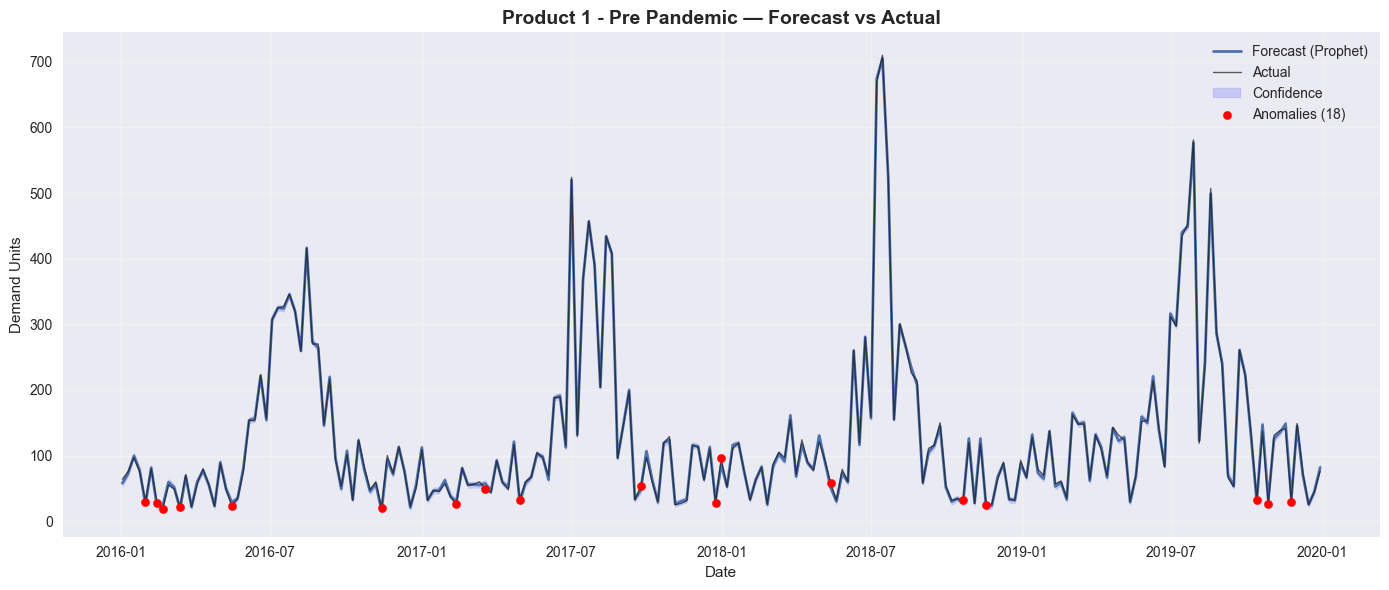

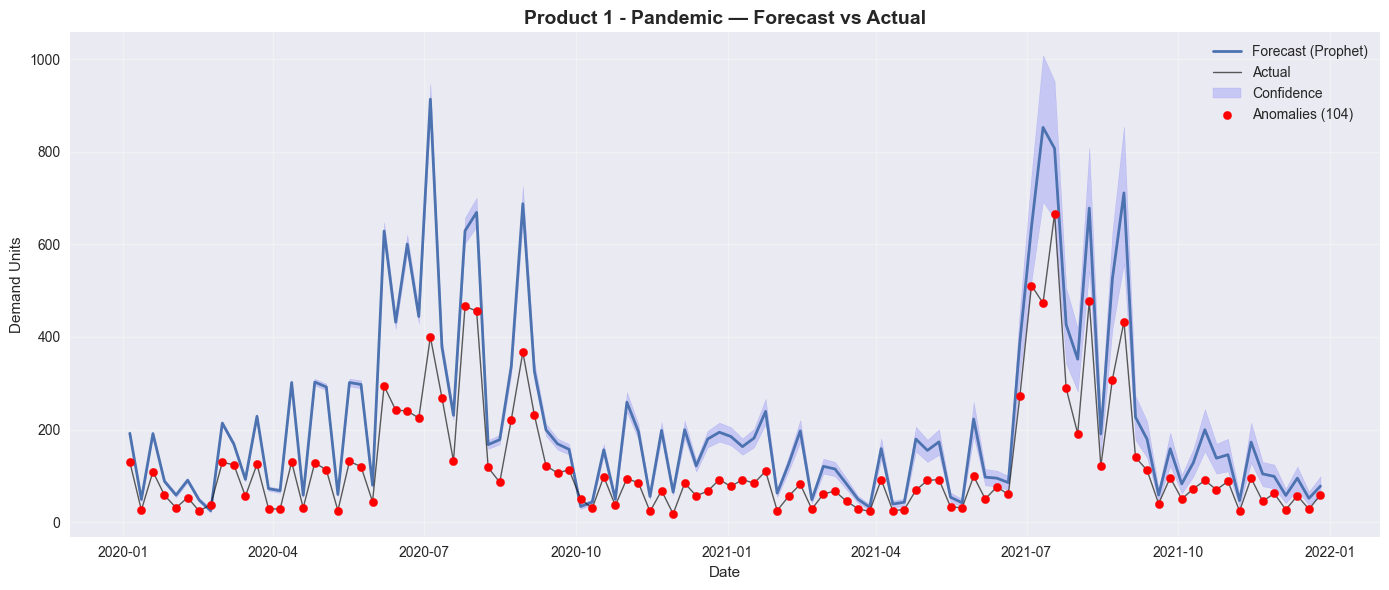

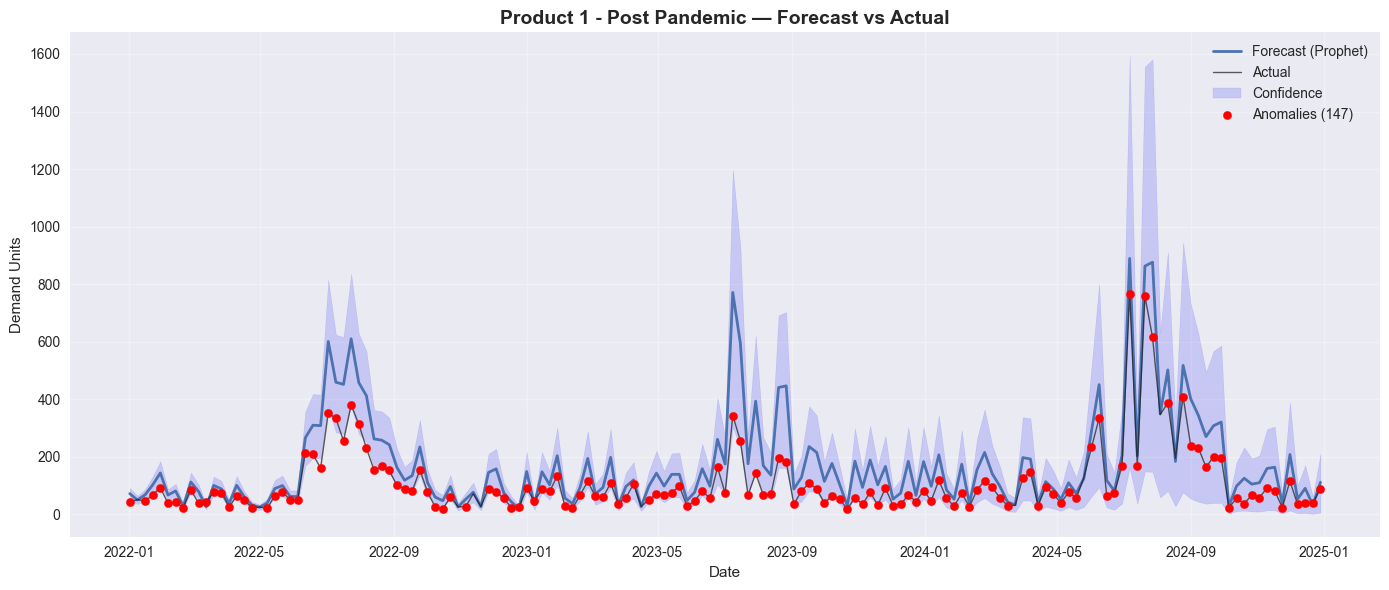

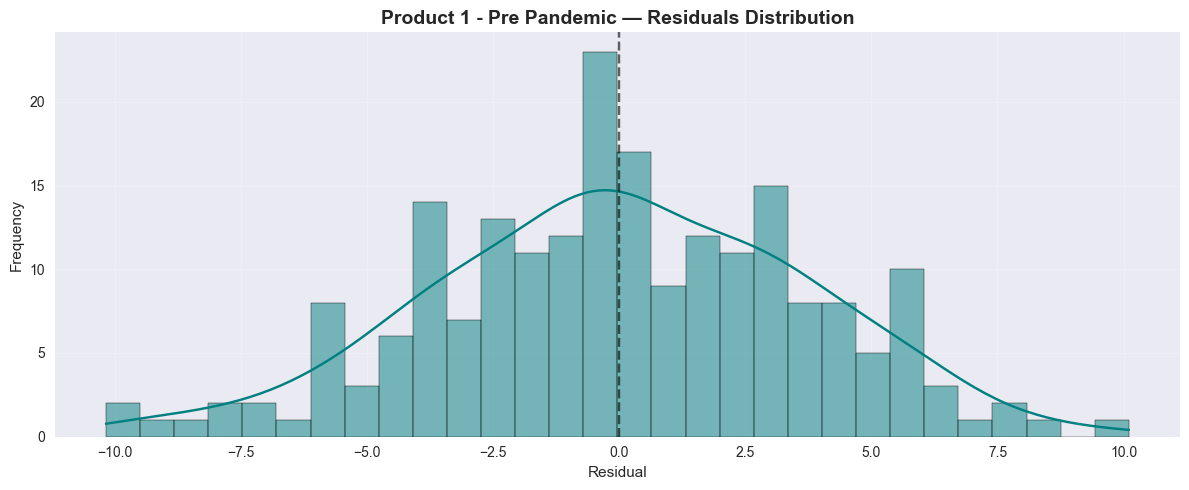

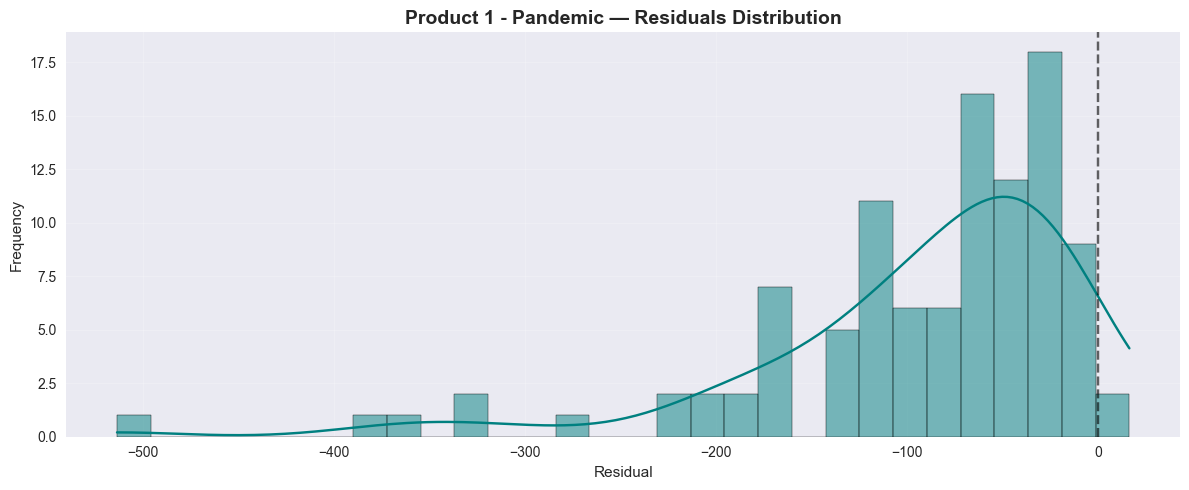

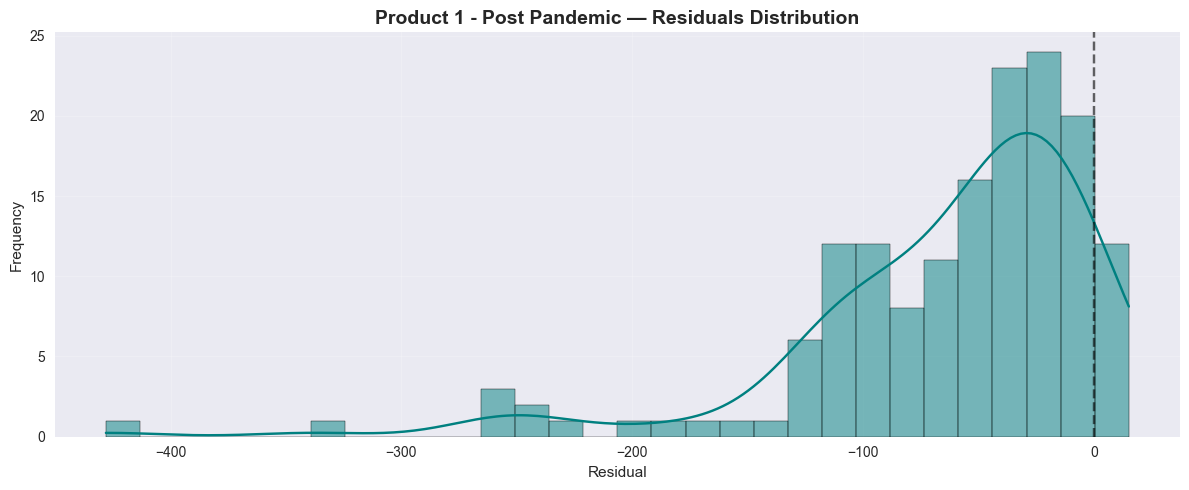

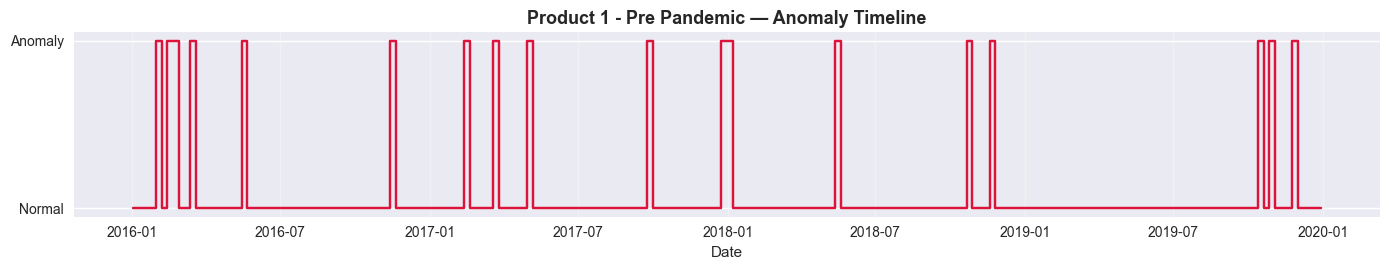

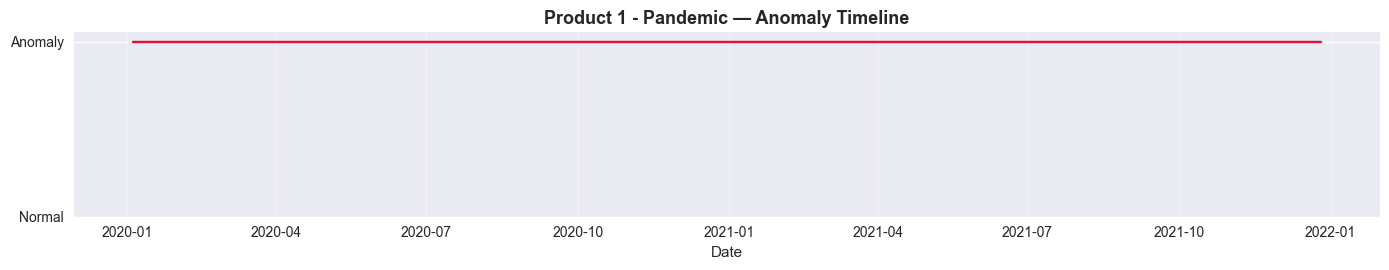

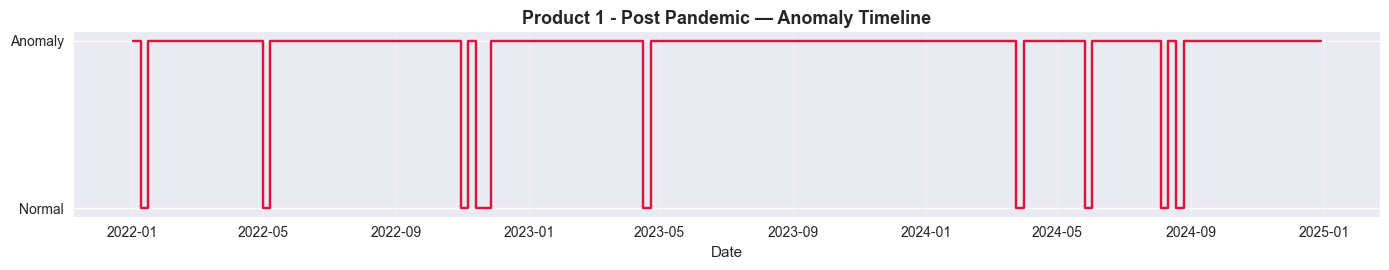

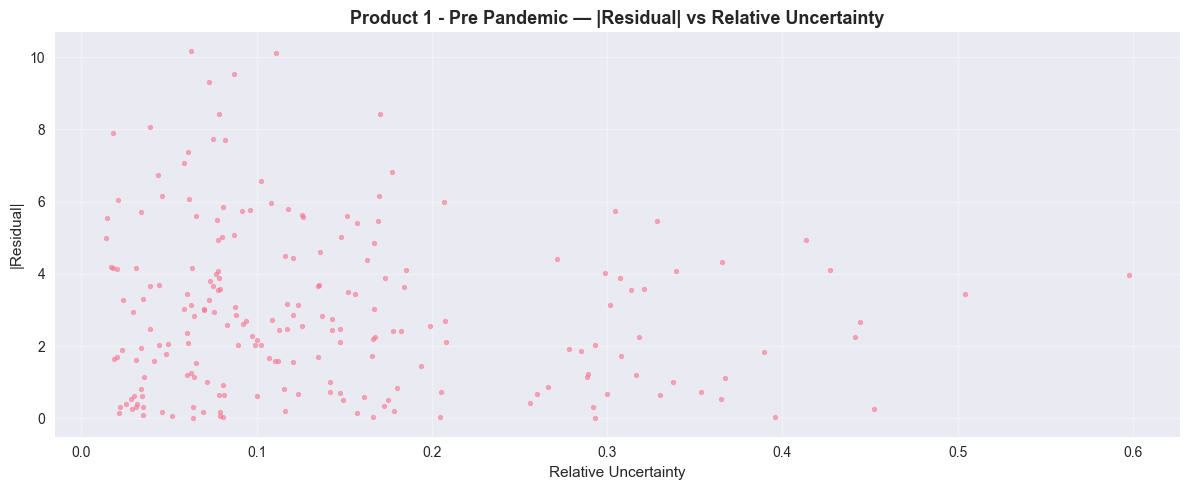

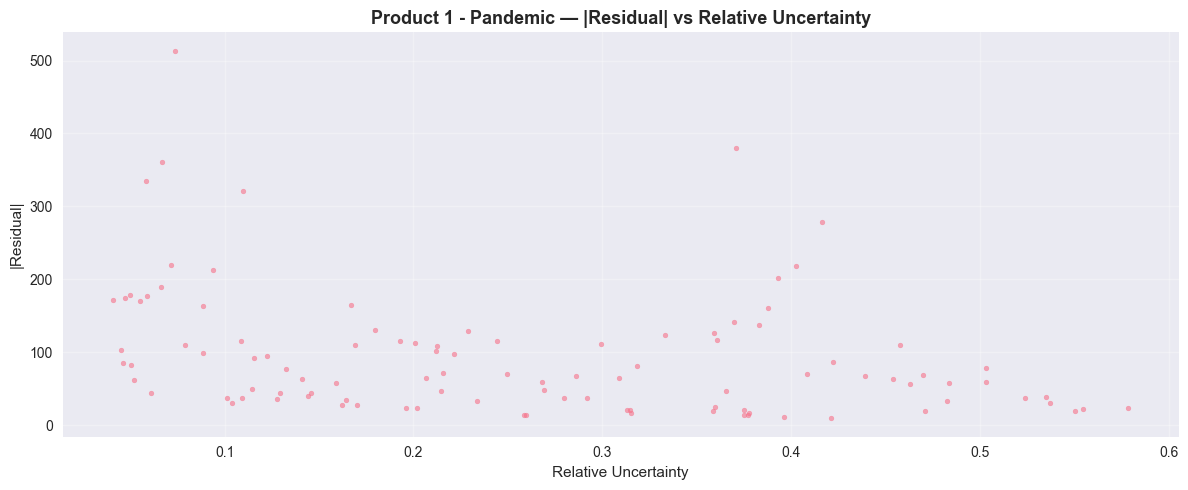

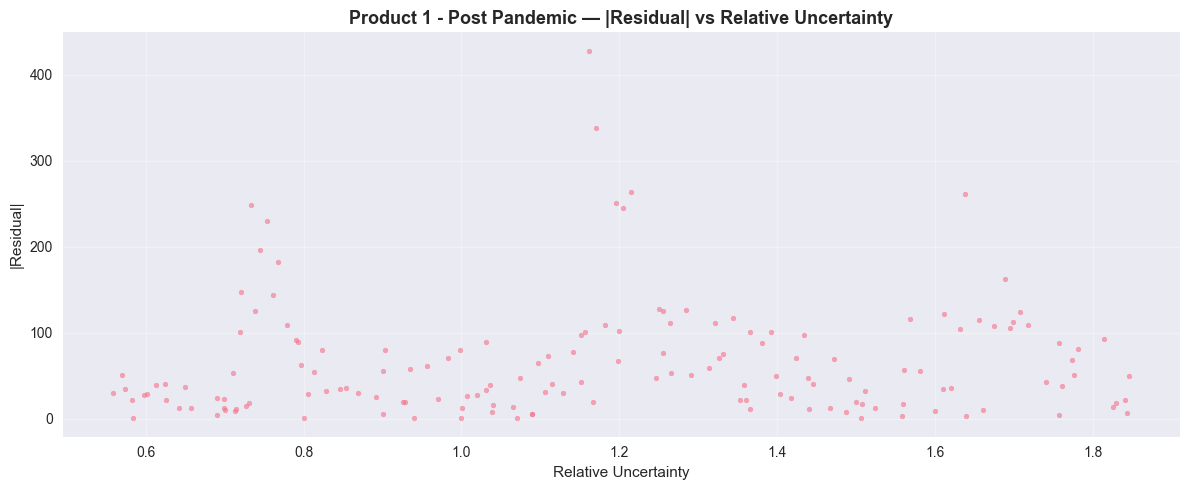

In [388]:
def contain_product11():
    forecasts = {}
    residuals = {}
    anomalies = {}

    if 'detector11' in globals():
        try:
            forecasts = getattr(detector11, 'forecasts', {}) or {}
            residuals = getattr(detector11, 'residuals', {}) or {}
            anomalies = getattr(detector11, 'anomalies', {}) or {}
        except Exception:
            pass

    return forecasts, residuals, anomalies

forecasts, residuals, anomalies = contain_product11()

def residuals_framing(regime):
    rs = residuals.get(regime)
    if rs is not None and len(rs) > 0 and 'residuals' in rs.columns:  # Fixed: 'residual' -> 'residuals'
        return rs.copy()
    fc = forecasts.get(regime)
    if fc is not None and len(fc) > 0 and {'yhat','ds'}.issubset(fc.columns):
        df_tmp = fc[['ds','yhat']].copy()
        if 'y' in fc.columns:
            df_tmp['y'] = fc['y']
        elif regime in anomalies and 'y' in anomalies[regime].columns:
            df_tmp = df_tmp.merge(anomalies[regime][['ds','y']], on='ds', how='left')
        if 'y' in df_tmp.columns:
            df_tmp['residuals'] = df_tmp['y'] - df_tmp['yhat']  # Fixed: 'residual' -> 'residuals'
            return df_tmp
    return None

all_regimes = ['pre_pandemic', 'pandemic', 'post_pandemic']
available_regimes = [r for r in all_regimes if (r in forecasts) or (r in residuals) or (r in anomalies)]

if len(available_regimes) == 0:
    print("No forecast/residual/anomaly data found for Product 1. Run Cell 2 first.")
else:
    # 1. Forecast vs Actual with Anomalies
    for regime in available_regimes:
        fc = forecasts.get(regime)
        an = anomalies.get(regime)

        if fc is None or len(fc) == 0:
            continue

        plt.figure(figsize=(14, 6))
        plt.plot(fc['ds'], fc['yhat'], 'b-', label='Forecast (Prophet)', linewidth=2)
        if 'y' in fc.columns and fc['y'].notna().any():
            plt.plot(fc['ds'], fc['y'], 'k-', alpha=0.7, label='Actual', linewidth=1)

        if {'yhat_lower','yhat_upper'}.issubset(fc.columns):
            plt.fill_between(fc['ds'], fc['yhat_lower'], fc['yhat_upper'], color='blue', alpha=0.15, label='Confidence')

        # Fixed: 'ensemble_anomaly' -> 'anomaly_ensemble'
        if an is not None and len(an) > 0 and 'anomaly_ensemble' in an.columns:
            points = an[an['anomaly_ensemble'] == 1]
            if len(points) > 0:
                y_col = 'y' if 'y' in an.columns else 'yhat'
                plt.scatter(points['ds'], points[y_col], color='red', s=35, zorder=5, label=f'Anomalies ({len(points)})')

        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — Forecast vs Actual", fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Demand Units')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 2. Residuals Distribution
    for regime in available_regimes:
        rs = residuals.get(regime)
        # Fixed: 'residual' -> 'residuals'
        if rs is None or len(rs) == 0 or 'residuals' not in rs.columns:
            continue
        plt.figure(figsize=(12, 5))
        sns.histplot(rs['residuals'].dropna(), bins=30, kde=True, color='teal')
        plt.axvline(0, color='black', linestyle='--', alpha=0.6)
        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — Residuals Distribution", fontsize=14, fontweight='bold')
        plt.xlabel('Residual')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    # 3. Anomaly Timeline
    for regime in available_regimes:
        an = anomalies.get(regime)
        # Fixed: 'ensemble_anomaly' -> 'anomaly_ensemble'
        if an is None or len(an) == 0 or 'anomaly_ensemble' not in an.columns:
            print(f"No anomaly data found for {regime}")
            continue
        series = an[['ds', 'anomaly_ensemble']].copy()
        series = series.sort_values('ds')
        plt.figure(figsize=(14, 2.8))
        plt.step(series['ds'], series['anomaly_ensemble'].astype(int), where='post', color='crimson')
        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — Anomaly Timeline", fontsize=13, fontweight='bold')
        plt.yticks([0,1],["Normal","Anomaly"])
        plt.xlabel('Date')
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4. Residual vs Uncertainty Plot
    for regime in available_regimes:
        fc = forecasts.get(regime)
        if fc is None:
            continue
        if not {'yhat_lower','yhat_upper','ds'}.issubset(fc.columns):
            continue
        rs = residuals_framing(regime)
        # Fixed: 'residual' -> 'residuals'
        if rs is None or 'residuals' not in rs.columns:
            continue
        tmp = rs[['ds','residuals']].merge(fc[['ds','yhat','yhat_lower','yhat_upper']], on='ds', how='inner')
        if len(tmp) == 0:
            continue
        tmp['rel_uncertainty'] = (tmp['yhat_upper'] - tmp['yhat_lower']).abs() / (tmp['yhat'].abs() + 1e-6)
        plt.figure(figsize=(12,5))
        plt.scatter(tmp['rel_uncertainty'], tmp['residuals'].abs(), s=12, alpha=0.6)
        plt.title(f"Product 1 - {regime.replace('_',' ').title()} — |Residual| vs Relative Uncertainty", fontsize=13, fontweight='bold')
        plt.xlabel('Relative Uncertainty')
        plt.ylabel('|Residual|')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()